# Import necessary dependencies and settings

In [91]:
import pandas as pd
import numpy as np
import string
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
import nltk.corpus 
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer

from gensim.models.word2vec import Word2Vec

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kiranrawat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading the Data

In [92]:
train_news = pd.read_csv('../data/processed/train.csv')
val_news = pd.read_csv('../data/processed/val.csv')
test_news = pd.read_csv('../data/processed/test.csv')

# Understanding the data distribution

In [93]:
print("====Label Distribution in Training Data ====")
print(train_news['label'].value_counts())
print("====Label Distribution in Validation Data ====")
print(val_news['label'].value_counts())
print("====Label Distribution in Test Data====")
print(test_news['label'].value_counts())

====Label Distribution in Training Data ====
True     5752
False    4488
Name: label, dtype: int64
====Label Distribution in Validation Data ====
True     668
False    616
Name: label, dtype: int64
====Label Distribution in Test Data====
True     714
False    553
Name: label, dtype: int64


By seeing the label's distribution, it seems like a balanced class. As number of 'True' and 'False' lables are kind of equally distributed in the dataset.

In [94]:
train_news.groupby('label').describe()

statement                                                               
          count unique                                                top freq
label                                                                         
False      4488   4481  On changing the rules for filibusters on presi...    3
True       5752   5746          Twenty million Americans are out of work.    2

In [103]:
print(train_news['statement'][AA]) ## issue with the data

NameError: name 'AA' is not defined

In [96]:
train_news['statement']

0        Says the Annies List political group supports ...
1        When did the decline of coal start? It started...
2        Hillary Clinton agrees with John McCain "by vo...
3        Health care reform legislation is likely to ma...
4        The economic turnaround started at the end of ...
                               ...                        
10235    There are a larger number of shark attacks in ...
10236    Democrats have now become the party of the [At...
10237    Says an alternative to Social Security that op...
10238    On lifting the U.S. Cuban embargo and allowing...
10239    The Department of Veterans Affairs has a manua...
Name: statement, Length: 10240, dtype: object

from above information, we know that:

1. About 44% of the statements are classified as a True.
2. There are some duplicate messages, since the number of unique values lower than the count values of the text.

In the next part, lext check the length of each text messages to see whether it is correlated with the text classified as a True or False.

In [46]:
train_news['length'] = train_news['statement'].apply(len)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x120dfb4f0>,
      dtype=object)

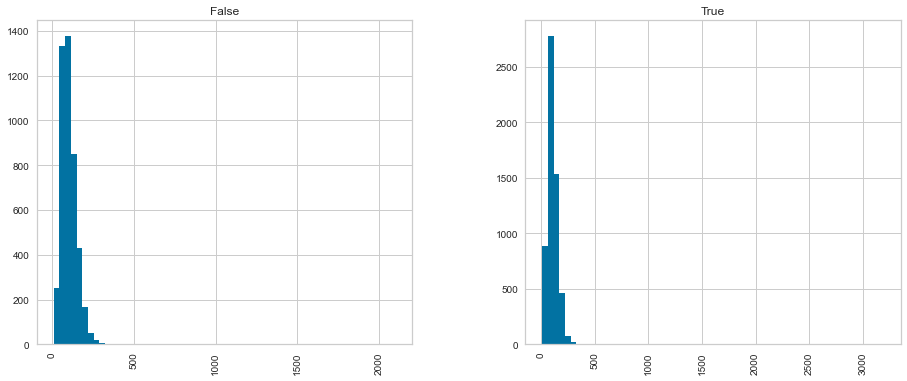

In [47]:
train_news.hist(column='length',by='label',bins=60, figsize=(15,6))

from above figure, we can see almost both True and False statements have length under 500.

# Text pre-processing

In [48]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [75]:
normalize_corpus(train_news['statement'][5])

array('chicago bears starting quarterbacks last years total number tenured uw faculty fired last two decades',
      dtype='<U101')

In [77]:
def process_text(text):
    '''
    What will be covered:
    1. Lower case and remove special characters\whitespaces
    1. Remove punctuation
    2. Remove stopwords
    3. Return list of clean text words
    '''
    #1  
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    
    #2
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    #3
    clean_words = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    
    #4
    return clean_words

In [79]:
train_news['statement'].apply(process_text).head(10)

0    [Says, Annies, List, political, group, support...
1    [decline, coal, start, started, natural, gas, ...
2    [Hillary, Clinton, agrees, John, McCain, votin...
3    [Health, care, reform, legislation, likely, ma...
4           [economic, turnaround, started, end, term]
5    [Chicago, Bears, starting, quarterbacks, last,...
6    [Jim, Dunnam, lived, district, represents, years]
7    [Im, person, stage, worked, actively, last, ye...
8    [However, took, million, Oregon, Lottery, fund...
9    [Says, GOP, primary, opponents, Glenn, Grothma...
Name: statement, dtype: object

## Feature Weighting

Not all words are equally important to a particular document / category. For example, while words like ‘murder’, ‘knife’ and ‘abduction’ are important to a crime related document, words like ‘news’ and ‘reporter’ may not be quite as important. 

### Binary Weighting
The most basic form of feature weighting, is binary weighting. Where if a word is present in a document, the weight is ‘1’ and if the word is absent the weight is ‘0’. 

### CountVectorizer

It Convert a collection of text documents to a matrix of token counts.


### Tfidf Weighting 

TF-IDF weighting where words that are unique to a particular document would have higher weights compared to words that are used commonly across documents. 

1. TF (Term Frequency): The number of times a word appears in a document divded by the total number of words in the document. Every document has its own term frequency.

2. IDF (Inverse Data Frequency): The log of the number of documents divided by the number of documents that contain the word w. Inverse data frequency determines the weight of rare words across all documents in the corpus.

3. Lastly, the TF-IDF is simply the TF multiplied by IDF.

In [83]:
count_vect = CountVectorizer(analyzer=process_text, min_df=0., max_df=1.)
cv_matrix = count_vect.fit_transform(train_news.statement)
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [84]:
# get all unique words in the corpus
vocab = count_vect.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab)

,000,AA,AAA,AARP,ABAs,ABC,ABCs,ACLU,ACORN,ACT,...,youve,yrs,yuppies,zero,zippo,zombies,zone,zones,zoning,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10236,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10237,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10238,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [102]:
dummy = pd.DataFrame(cv_matrix, columns=vocab)
dummy[dummy['AA'] == 1]

,000,AA,AAA,AARP,ABAs,ABC,ABCs,ACLU,ACORN,ACT,...,youve,yrs,yuppies,zero,zippo,zombies,zone,zones,zoning,zoo
8320,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [107]:
# print(train_news['statement'][1280]) ## issue with the data
process_text(train_news['statement'][1280])

['Hospitals',
 'doctors',
 'MRIs',
 'surgeries',
 'forth',
 'extensively',
 'used',
 'far',
 'expensive',
 'country',
 'many',
 'countries',
 'healthcare',
 'mittromney',
 'Former',
 'governor',
 'Massachusetts',
 'republican',
 'Fox',
 'News',
 'Sunday',
 'interview',
 'json',
 'barelytrue',
 'Obamacare',
 'cuts',
 'seniors',
 'Medicare',
 'healthcaremedicare',
 'edgillespie',
 'Republican',
 'strategist',
 'Washington',
 'DC',
 'republican',
 'campaign',
 'email',
 'json',
 'mostlytrue',
 'refusal',
 'many',
 'federal',
 'employees',
 'fly',
 'coach',
 'costs',
 'taxpayers',
 'million',
 'annually',
 'governmentefficiencytransparency',
 'newsmax',
 'Magazine',
 'website',
 'Florida',
 'none',
 'email',
 'solicitation',
 'json',
 'mostlytrue',
 'Florida',
 'spends',
 'million',
 'year',
 'children',
 'repeating',
 'preK',
 'rd',
 'grade',
 'education',
 'alexsink',
 'Florida',
 'democrat',
 'figures',
 'cites',
 'campaign',
 'website',
 'json',
 'true',
 'Milwaukee',
 'County',
 'Sher

In [105]:
print(train_news['statement'][8320]) ## issue with the data

Florida was the only state during my eight years to go from AA to AAA in its bond rating.


In [85]:
vocab

['000',
 'AA',
 'AAA',
 'AARP',
 'ABAs',
 'ABC',
 'ABCs',
 'ACLU',
 'ACORN',
 'ACT',
 'ADVISOR',
 'AFC',
 'AFLCIO',
 'AFSCME',
 'AGallup',
 'AGprivate',
 'AGs',
 'AIDS',
 'AIG',
 'AIGs',
 'AIPAC',
 'AK',
 'ALS',
 'ANWR',
 'ANYONE',
 'AP',
 'AR',
 'ATF',
 'ATMs',
 'ATVs',
 'Aaron',
 'Abbas',
 'Abbott',
 'Abdul',
 'Abedin',
 'Abele',
 'Aboard',
 'Abortion',
 'Abortionists',
 'Abortions',
 'Abraham',
 'AbrahamLincoln',
 'Abramoff',
 'Absolutely',
 'Abu',
 'Abuse',
 'Academy',
 'Access',
 'Accidents',
 'Accommodate',
 'According',
 'Accountability',
 'Accounts',
 'Accuses',
 'Acela',
 'Acorn',
 'Across',
 'Act',
 'Actalters',
 'Action',
 'Activist',
 'Actthan',
 'Actually',
 'Actuaries',
 'Adam',
 'Adams',
 'Adan',
 'Adegbile',
 'Adler',
 'Adlers',
 'Administration',
 'Administrations',
 'Admiral',
 'Adolf',
 'Adoptions',
 'Advanced',
 'Advancement',
 'Advantage',
 'Advisers',
 'Advisors',
 'Advisory',
 'Affairs',
 'Affairshealth',
 'Affirmative',
 'Affordable',
 'Afghan',
 'Afghanistan',


Here by doing ‘count_vect.fit_transform(train_news.statement)’, we are learning the vocabulary dictionary and it returns a Document-Term matrix. [n_samples, n_features]

In [53]:
tfidf_vect = TfidfVectorizer(use_idf=True, max_df=0.95, analyzer=process_text)
X_train_tfidf = tfidf_vect.fit_transform(train_news.statement)
X_train_tfidf.shape

(10240, 14694)

In [25]:
print(X_train_tfidf)

  (0, 7472)	0.3487778612305985
  (0, 5396)	0.2913344923941701
  (0, 13747)	0.4111721462668922
  (0, 13467)	0.268763909950058
  (0, 9014)	0.29572900100023347
  (0, 11437)	0.288299097736884
  (0, 3292)	0.42942130476966167
  (0, 1168)	0.42942130476966167
  (0, 4480)	0.11315616700304243
  (1, 5513)	0.20276327129406949
  (1, 1523)	0.2739440793861925
  (1, 5172)	0.24939236562772774
  (1, 2529)	0.21935004602848507
  (1, 4098)	0.16242753464879256
  (1, 6113)	0.295266927264955
  (1, 13828)	0.1992848257109974
  (1, 8841)	0.22394629275523875
  (1, 10660)	0.2739440793861925
  (1, 13219)	0.4969030230072441
  (1, 13218)	0.2798176297170201
  (1, 6780)	0.2758031142293708
  (1, 7386)	0.3062283783186632
  (2, 2932)	0.2845763297257711
  (2, 7809)	0.39530812320324743
  (2, 6142)	0.3295319830510894
  :	:
  (10237, 4545)	0.36157922245718305
  (10237, 4917)	0.1467873648865444
  (10237, 4480)	0.08541385115156025
  (10238, 10075)	0.43475306416516835
  (10238, 1908)	0.41482991954064935
  (10238, 8024)	0.4237885

## Visualizing patterns in feature vectors in 2D Space

1. PCA (Principal component analysis)
2. TSNE (T-distributed )


**Training Data**

In [108]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=2, random_state=0)
# pcs = pca.fit_transform(X_train_tfidf)
# labels = ap.labels_
# categories = list(train_news.label)
# plt.figure(figsize=(8, 6))

# for i in range(len(labels)):
#     label = labels[i]
#     color = 'orange' if label == 0 else 'blue' if label == 1 else 'green'
#     annotation_label = categories[i]
#     x, y = pcs[i]
#     plt.scatter(x, y, c=color, edgecolors='k')
#     plt.annotate(annotation_label, xy=(x+1e-4, y+1e-3), xytext=(0, 0), textcoords='offset points')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


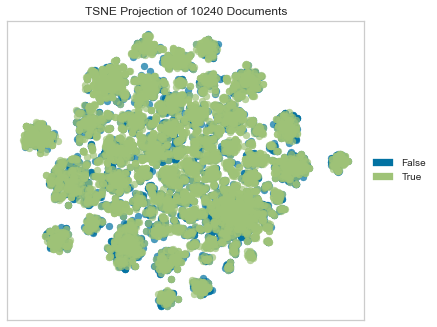

(10240, 14694)


In [17]:
from yellowbrick.text import TSNEVisualizer

tfidf = TfidfVectorizer(use_idf=True, max_df=0.95, analyzer=process_text)
countv = CountVectorizer(binary=True, max_df=0.95, analyzer=process_text)

tfidfvect = tfidf.fit_transform(train_news['statement'].values)
countvect = countv.fit_transform(train_news['statement'].values)

y = train_news.label.values
# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(tfidfvect, y)
tsne.show()

print(tfidfvect.shape)

**Validation Data**

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


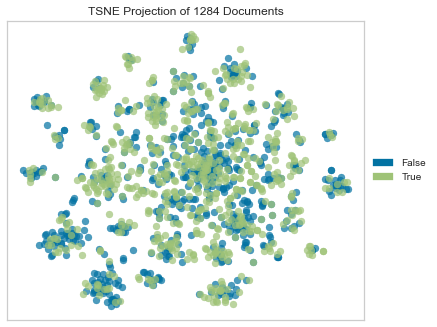

(1284, 4717)


In [29]:
tfidf = TfidfVectorizer(use_idf=True, max_df=0.95, analyzer=process_text)
countv = CountVectorizer(binary=True, max_df=0.95, analyzer=process_text)

tfidfvect = tfidf.fit_transform(val_news['statement'].values)
countvect = countv.fit_transform(val_news['statement'].values)

y = val_news.label.values
# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(tfidfvect, y)
tsne.show()

print(tfidfvect.shape)

**Test Data**

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


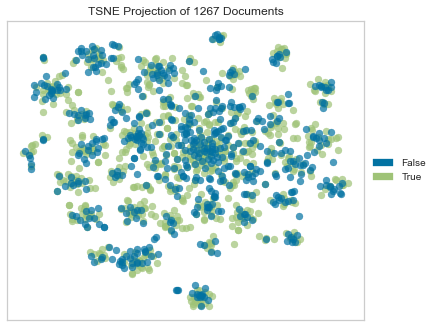

(1267, 4699)


In [30]:
tfidf = TfidfVectorizer(use_idf=True, max_df=0.95, analyzer=process_text)
countv = CountVectorizer(binary=True, max_df=0.95, analyzer=process_text)

tfidfvect = tfidf.fit_transform(test_news['statement'].values)
countvect = countv.fit_transform(test_news['statement'].values)

y = test_news.label.values
# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(tfidfvect, y)
tsne.show()

print(tfidfvect.shape)